In [1]:
%%javascript
var kernel = Jupyter.notebook.kernel;
var command = ["notebookUrl = ",
               "'", window.location, "'" ].join('')
kernel.execute(command)

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import Markdown
from IPython.display import display

user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/insar_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "insar_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "insar_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "insar_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

In [3]:
import contextlib
import csv
from datetime import datetime
import h5py
import os
from pathlib import Path
import re
import urllib
import zipfile

from ipyfilechooser import FileChooser

from osgeo import gdal
import numpy as np
import mintpy.view
import mintpy.tsview
import mintpy.plot_network
import mintpy.plot_transection
import mintpy.plot_coherence_matrix
import mintpy.objects.insar_vs_gps
import mintpy.utils

import asf_notebook as asfn

/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/hyp3_sdk/asf_search.py:8: FutureWarning: 
hyp3_sdk.asf_search is deprecated and functionality has been superseded by the `asf_search` package available on conda-forge and PyPI. See: https://github.com/asfadmin/Discovery-asf_search
  warnings.warn('\nhyp3_sdk.asf_search is deprecated and functionality has been '


In [4]:
fc = FileChooser('/home/jovyan/notebooks/avo_insar/processings')
display(fc)

FileChooser(path='/home/jovyan/notebooks/avo_insar/processings', filename='', title='', show_hidden=False, sel…

**Define a project name and create a MintPy directory in which to store files output during our analysis**

In [5]:
# define the work directory
work_path = Path(fc.selected_path)
print(f"Work directory: {work_path}")

# define a project name
# proj_name = input("Enter a project name: ")
proj_name = str(work_path).split("/")[-1]

# define the MintPy time-series directory
mint_path = work_path/'MintPy'
if not mint_path.is_dir():
    mint_path.mkdir()
print(f"MintPy directory: {mint_path}")


#create a directory in which to store plots
plot_path = mint_path/"plots"
if not plot_path.is_dir():
    plot_path.mkdir()


Work directory: /home/jovyan/notebooks/avo_insar/processings/cleveland117
MintPy directory: /home/jovyan/notebooks/avo_insar/processings/cleveland117/MintPy


In [8]:
# remove the old analysis products
runcommand = "rm -rf " + str(mint_path)
!{runcommand}

In [10]:
@contextlib.contextmanager
def work_dir(work_pth):
  cwd = Path.cwd()
  os.chdir(work_pth)
  try:
      yield
  finally:
      os.chdir(cwd)

In [11]:
config = f'''# vim: set filetype=cfg:
mintpy.load.processor        = hyp3
##---------interferogram datasets:
mintpy.load.unwFile          = {work_path}/*/*unw_phase_clip.tif
mintpy.load.corFile          = {work_path}/*/*corr_clip.tif
##---------geometry datasets:
mintpy.load.demFile          = {work_path}/*/*dem_clip.tif
mintpy.load.incAngleFile     = {work_path}/*/*lv_theta_clip.tif
mintpy.load.azAngleFile      = {work_path}/*/*lv_phi_clip.tif
mintpy.load.waterMaskFile    = {work_path}/*/*water_mask_clip.tif

mintpy.reference.minCoherence = 0.75
'''

config_path = mint_path/f'{proj_name}.txt'

with open(config_path, 'w') as f:
    f.write(config)
    print(f"config file path: {config_path}\n")
    
with open(config_path, 'r') as f:
    for line in f.readlines():
        print(line)


# possible syntax:
# mintpy.reference.lalo        = 56.923918,-158.174251
# mintpy.reference.minCoherence = 0.5

config file path: /home/jovyan/notebooks/avo_insar/processings/unimak73/MintPy/unimak73.txt

# vim: set filetype=cfg:

mintpy.load.processor        = hyp3

##---------interferogram datasets:

mintpy.load.unwFile          = /home/jovyan/notebooks/avo_insar/processings/unimak73/*/*unw_phase_clip.tif

mintpy.load.corFile          = /home/jovyan/notebooks/avo_insar/processings/unimak73/*/*corr_clip.tif

##---------geometry datasets:

mintpy.load.demFile          = /home/jovyan/notebooks/avo_insar/processings/unimak73/*/*dem_clip.tif

mintpy.load.incAngleFile     = /home/jovyan/notebooks/avo_insar/processings/unimak73/*/*lv_theta_clip.tif

mintpy.load.azAngleFile      = /home/jovyan/notebooks/avo_insar/processings/unimak73/*/*lv_phi_clip.tif

mintpy.load.waterMaskFile    = /home/jovyan/notebooks/avo_insar/processings/unimak73/*/*water_mask_clip.tif



mintpy.reference.minCoherence = 0.75



In [ ]:
!smallbaselineApp.py --work-dir {mint_path}  {config_path}

<br>

<br>

<div class="alert alert-warning">
<font face="Calibri" size="3"> Re-analysis of a project is finished before this cell. All cells below are for debugging purposes. 
</font>
</div>

<br>

<br>

## 3.1. Load Data

**Run the `load_data` step**

- If you get a missing 'Height' attribute error, you are missing a DEM, which is an available option when ordering HyP3 InSAR products


In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data

The output of the loading step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata.  
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.). 

In [ ]:
inputs_path = mint_path/'inputs'
!ls $inputs_path

<div class="alert alert-info">
<b>info.py :</b> 
To get general infomation about a MintPy product, run info.py on the file.   
</div>

In [ ]:
!info.py $inputs_path/ifgramStack.h5

## 3.2. Modify the Network

**Run the `modify_network` step**

- If a water mask was provided, this step generates waterMask.h5
- Modify the network based on temporal/perpendicular baselines, date, num of connections etc.

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep modify_network

## 3.3. Plot the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- ifgramStack_coherence_spatialAvg.txt: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- Network.pdf: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. 
- CoherenceMatrix.pdf shows the avergae coherence pairs between all available pairs in the stack.

In [ ]:
%matplotlib inline
with work_dir(mint_path):
    mintpy.plot_network.main([f'{inputs_path}/ifgramStack.h5'])
    plots = ['bperpHistory.pdf', 'coherenceHistory.pdf', 'coherenceMatrix.pdf', 'network.pdf']
    for p in plots:
        if (mint_path/p).exists():
            (mint_path/p).rename(f'{plot_path}/{p}')
            

## 3.4. Set the Reference Point

**Run the `reference_point` step**

The interferometric phase is a relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore, we need to reference all interferograms to a common reference pixel.

The `reference_point` step selects a common reference pixel for the stack of interferograms. The default approach of MintPy is to choose a pixel with the highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.   

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_point

**Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the ifgramStack.h5 file. To see the attributes of the file run info.py**

In [ ]:
!info.py $inputs_path/ifgramStack.h5 | egrep 'REF_'

## 3.5. Run a Quick Overview

**Run the `quick_overview` step**

- Assess possible groud deformation using the velocity from traditional interferogram stacking 
    - *reference: Zebker et al. (1997, JGR)*
- Assess distribution of phase unwrapping error from the number of interferogram triplets with non-zero integer ambiguity of closure phase 
    - *reference: T_int in Yunjun et al. (2019, CAGEO). Related to section 3.2, equation (8-9) and Fig. 3d-e.*

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep quick_overview

## 3.6. Inverting the Small Baseline network

**Run the `invert_network` step**

- Invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date
- By default mintpy selects the first acquisition
- The estimated time-series is converted to distance change from radar to target and is provided in meters. 

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep invert_network

## 3.7. Correct for Tropospheric Propagation Delays

**Run the `correct_troposphere` step**

- Uses ECMWF [ERA5 climate reanalysis pressure data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20)%20AND%20(%20%22Provider:%20Copernicus%20C3S%22%20))&text=pressure)
- CDS limits ECMWF archive requests to 50, so your requests may be queued until there is space.
    - https://cds.climate.copernicus.eu/live/queue

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_troposphere 

## 3.8. Correct for DEM Errors

**Run the `correct_topography` step**

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_topography

**Plot the corrected, inverted time series steps**

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is timeseries file: /home/jovyan/notebooks/avo_insar/processings/edgecumbe50/MintPy/timeseries_ERA5_demErr.h5 in float32 format
file size in y/x: (464, 271)
num of datasets in file timeseries_ERA5_demErr.h5: 106
datasets to exclude (0):
[]
datasets to display (106):
['timeseries-20170327', 'timeseries-20170408', 'timeseries-20170502', 'timeseries-20170526', 'timeseries-20170806', 'timeseries-20170818', 'timeseries-20170911', 'timeseries-20170923', 'timeseries-20171017', 'timeseries-20171029', 'timeseries-20171110', 'timeseries-20180310', 'timeseries-20180403', 'timeseries-20180415', 'timeseries-20180427', 'timeseries-20180509', 'timeseries-20180521', 'timeseries-20180614', 'timeseries-20180626', 'timeseries-20180708', 'timeseries-20180720', 'timeseries-20180801', 'timeseries-20180906', 'timeseries-20180918', 'timeseries-20180930', 'timeseries-20181012', 'timeseries-20181024', 'timeseries-20190410', 'timeseries-20190422', 

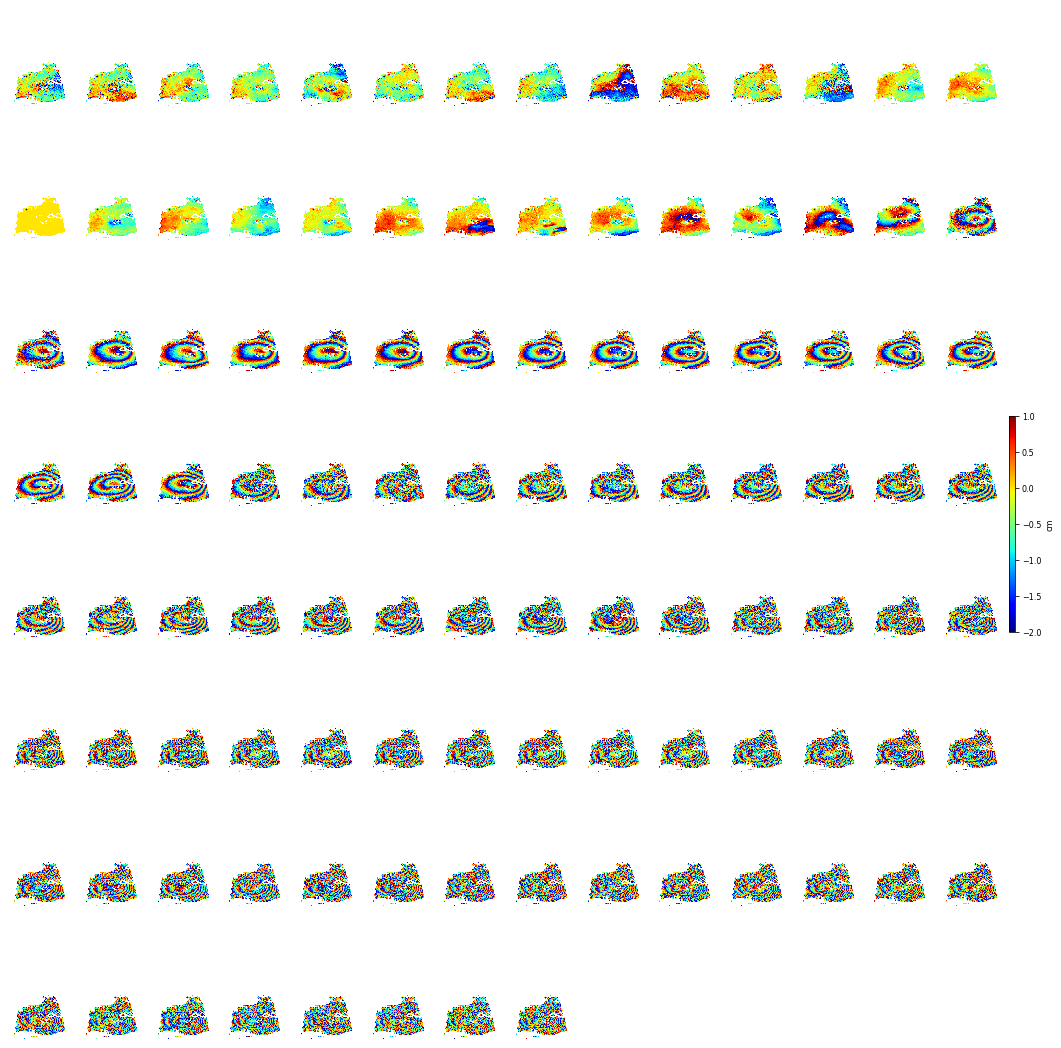

In [13]:
scp_args = f'{mint_path}/timeseries_ERA5_demErr.h5 --wrap --wrap-range -2 1 --notitle --notick --noaxis --dpi 600 --figsize 15 15 --outfile {plot_path}/inverted_ts.png'
mintpy.view.main(scp_args.split())

## 3.9. Calculate the Root Mean Square (RMS) of Residual Phase Time-Series for Each Acquisition

**Run the `residual_RMS` step**

- *reference: Yunjun et al. (2019, section 4.9 and 5.4)*
- To remove the long wavelength component in space, a phase ramp is removed for each acquisition
- Sets optimal reference date to date with min RMS
- Sets exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep residual_RMS

## 3.10. Reference the Entire Time-Series to One Date in Time

**Run the `reference_date` step**

- *reference: Yunjun et al. (2019, section 4.9)*

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_date

## 3.11. Estimate The Long-Term Velocity Rate

**Run the `velocity` step**

The timeseries file contains three datasets:
- the `time-series` dataset, which is the interferometric range change for each acquisition relative to the reference acquisition
- the `date` dataset, which contains the acquisition date for each acquisition
- the `bperp` dataset, which contains the timeseries of the perpendicular baseline 

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. 

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep velocity

In [ ]:
scp_args = f'{mint_path}/velocity.h5 velocity -v -10 10 --dpi 600 --figsize 15 15 --outfile {plot_path}/velocity.png'
mintpy.view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
    The line of sight (LOS) for this descending Sentinel-1 track is up and east from ground to radar.
</div>

## 3.12. Geocode velocity.h5 in Preparation for Creating a velocity.kmz

**Run the `geocode` step**

- This is unnecessary for geocoded HyP3 data but would be needed for non-geocoded data

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep geocode

## 3.13. Create a kmz File

**Run the `google_earth` step**

In [ ]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep google_earth

# 4. Error analysis (signal vs noise)

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in MintPy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 4.1. Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.

### 4.1.1. Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion.

In [ ]:
%matplotlib inline
scp_args = f"{mint_path}/avgSpatialCoh.h5 --dpi 600 --figsize 15 15 --outfile {plot_path}/avg_spatial_coh.png"
mintpy.view.main(scp_args.split())

### 4.1.2. Temporal coherence

In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms. 

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

In [ ]:
%matplotlib inline
scp_args = f"{mint_path}/temporalCoherence.h5 --dpi 600 --figsize 15 15 --outfile {plot_path}/temporal_coh.png"
mintpy.view.main(scp_args.split())

## 4.2. Velocity error analysis

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset. 

In [ ]:
%matplotlib inline
scp_args = f'{mint_path}/velocity.h5 velocityStd -v 0 0.2 --dpi 600 --figsize 15 15 --outfile {plot_path}/velocity_err.png'
mintpy.view.main(scp_args.split())

Note that the plot above is the velocity error, not the velocity. The errors generally increase with distance from the reference point and also increase for points with elevations different from the reference point because of topographically correlated water vapor variations that are especially strong in this area.

## 4.3. Compare InSAR time-series with GPS time-series in LOS direction

- http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html
- http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt

### 4.3.1. Identify Potential GPS stations

**Write the University of Nevada, Reno GPS station holdings metadata to GPS_stations.csv**

In [ ]:
with work_dir(mint_path):
    url = 'http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt'
    response = urllib.request.urlopen(url, timeout=5)
    content = response.read()
    rows = content.decode('utf-8').splitlines()
    holdings_txt = Path('.')/'DataHoldings.txt'
    if holdings_txt.exists():
        holdings_txt.unlink()

with open(f'{mint_path}/GPS_stations.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',', escapechar=',', quoting=csv.QUOTE_NONE)
    for row in rows:
        csv_writer.writerow([re.sub('\s+', ' ', row)])

**Build a list of GPS stations within your area of interest and select one**

In [ ]:
# get the InSAR stack's corner coordinates
with h5py.File(f"{mint_path}/inputs/geometryGeo.h5", 'r') as f:
    lon_west = float(f.attrs['LON_REF1'])
    lon_east = float(f.attrs['LON_REF2'])
    lat_south = float(f.attrs['LAT_REF1'])
    lat_north = float(f.attrs['LAT_REF3'])

# get the start and end dates of the timeseries
info = gdal.Info(f"{mint_path}/timeseries_ERA5_demErr.h5", format='json')
ts_start = info['metadata']['']['START_DATE']
ts_start = datetime.strptime(ts_start, '%Y%m%d')
ts_end = info['metadata']['']['END_DATE']
ts_end = datetime.strptime(ts_end, '%Y%m%d')

# find all stations that have data within the ts time range,
# are located within the AOI and at an unmasked pixel location
gps_stations = list()
with open(f'{mint_path}/GPS_stations.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in list(csv_reader)[1:]:
        begin_date = datetime.strptime(row[7], '%Y-%m-%d')
        mod_date = datetime.strptime(row[9], '%Y-%m-%d')
        lat = float(row[1])
        if float(row[2]) > 180:
            lon = float(row[2]) - 360
        else:
            lon = float(row[2])

        n = [lat, lon]
        a = [lat_north, lon_west]
        b = [lat_south, lon_west]
        c = [lat_south, lon_east]
        ab = np.subtract(a, b)
        an = np.subtract(a, n)
        bc = np.subtract(b, c)
        bn = np.subtract(b, n)

        in_aoi = 0 <= np.dot(ab, an) <= np.dot(ab, ab) and 0 <= np.dot(bc, bn) <= np.dot(bc, bc)
        in_date_range = ts_start >= begin_date and ts_end <= mod_date
        
        if in_aoi and in_date_range:
            vel_file = f'{mint_path}/velocity.h5'
            atr = mintpy.utils.readfile.read_attribute(vel_file)
            coord = mintpy.utils.utils.coordinate(atr, lookup_file=f'{mint_path}/inputs/geometryRadar.h5')
            y, x = coord.geo2radar(lat, lon)[:2]
            msk = mintpy.utils.readfile.read(f'{mint_path}/maskTempCoh.h5')[0]
            box = (x, y, x+1, y+1)
            masked = not msk[y, x]
            if not masked:
                gps_stations.append(row[0].strip())
                
if len(gps_stations) > 0:
    gps_station = asfn.select_parameter(gps_stations)
    print("Select a GPS station")
    display(gps_station)
else:
    print("No GPS stations found.")

In [ ]:
%matplotlib notebook
scp_args = f"{mint_path}/velocity.h5 velocity --show-gps --ref-gps {gps_station.value} --gps-comp enu2los --gps-label --figsize 9 9"
with work_dir(mint_path):
    mintpy.view.main(scp_args.split())

In [ ]:
with work_dir(plot_path):
    mintpy.objects.insar_vs_gps.plot_insar_vs_gps_scatter(vel_file=f'{mint_path}/velocity.h5',
                              ref_gps_site=gps_station.value,
                              csv_file=f'{mint_path}/gps_enu2los.csv',
                              msk_file=f'{mint_path}/maskTempCoh.h5')

# 5. Plotting a Motion Transect 

**Select the transect to plot**

In [ ]:
%matplotlib notebook
image_file = f"{mint_path}/temporalCoherence.h5"
img = gdal.Open(image_file)
rasterstack = img.ReadAsArray()

line = asfn.LineSelector(rasterstack, 9, 9)

In [ ]:
amp = list(work_path.glob('*/*_amp_clip.tif'))[0]
amp = gdal.Open(str(amp))
geotrans = amp.GetGeoTransform()

def geolocation(x, y, geotrans):
    return [geotrans[0]+x*geotrans[1], geotrans[3]+y*geotrans[5]]

try:
    pnt_1 = geolocation(line.pnt1[0][0], line.pnt1[0][1], geotrans)
    pnt_2 = geolocation(line.pnt2[0][0], line.pnt2[0][1], geotrans)
    print(f"point 1: {pnt_1}")
    print(f"point 2: {pnt_2}")
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error may occur if a line was not selected.</text>'))

In [ ]:
%matplotlib inline
scp_args = f'{mint_path}/velocity.h5 --start-lalo {pnt_1[1]} {pnt_1[0]} --end-lalo {pnt_2[1]} {pnt_2[0]} --outfile x'
with work_dir(plot_path):
    mintpy.plot_transection.main(scp_args.split())

# 6. Plot the Cumulative Displacement Map and Point Displacement Time Series

- Use the `Time` bar below the Cumulative Displacement Map to view displacements for different time periods
- Click on the Cumulative Displacement Map to select points for displaying Point Displacement Time-Series

In [ ]:
%matplotlib notebook
mintpy.tsview.main([f'{mint_path}/timeseries.h5', f'-d={mint_path}/inputs/geometryGeo.h5'])

tsview.py /home/jovyan/lost+found/processings/trident_clip/MintPy/timeseries_ERA5_demErr.h5 -d=/home/jovyan/lost+found/processings/trident_clip/MintPy/inputs/geometryGeo.h5
open timeseries file: timeseries_ERA5_demErr.h5
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 854, 399)
subset coverage in y/x: (0, 0, 854, 399)
data   coverage in lat/lon: (-155.53288905803527, 58.43729685700073, -154.59884536801903, 58.00089939527184)
subset coverage in lat/lon: (-155.53288905803527, 58.43729685700073, -154.59884536801903, 58.00089939527184)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
reading timeseries from file /home/jovyan/lost+found/processings/trident_clip/MintPy/timeseries_ERA5_demErr.h5
reference to date: 20230814
read mask from file: maskTempCoh.h5
data    range: 

<IPython.core.display.Javascript object>


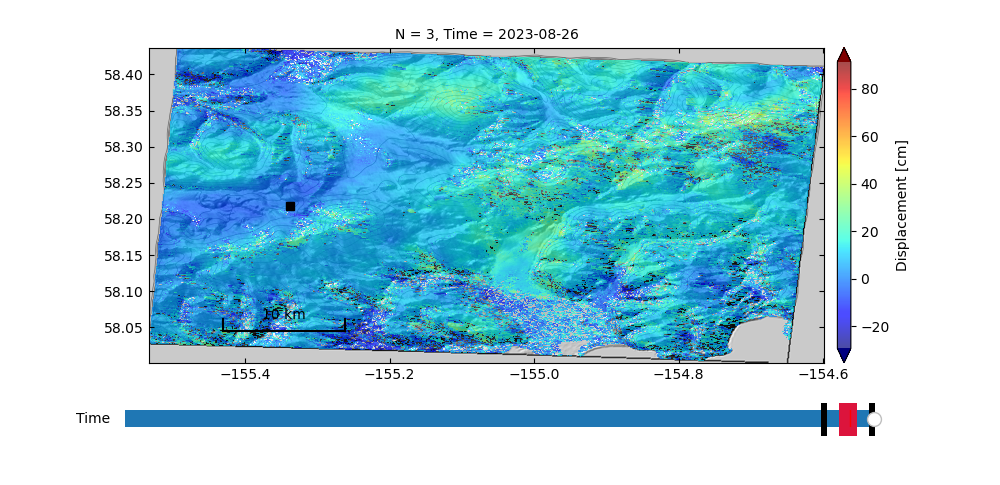

reading DEM: geometryGeo.h5 ...
display data in transparency: 0.7
plot in geo-coordinate
plotting DEM background ...
show shaded relief DEM
show contour in step of 200.0 m with smoothing factor of 3.0
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point


<IPython.core.display.Javascript object>


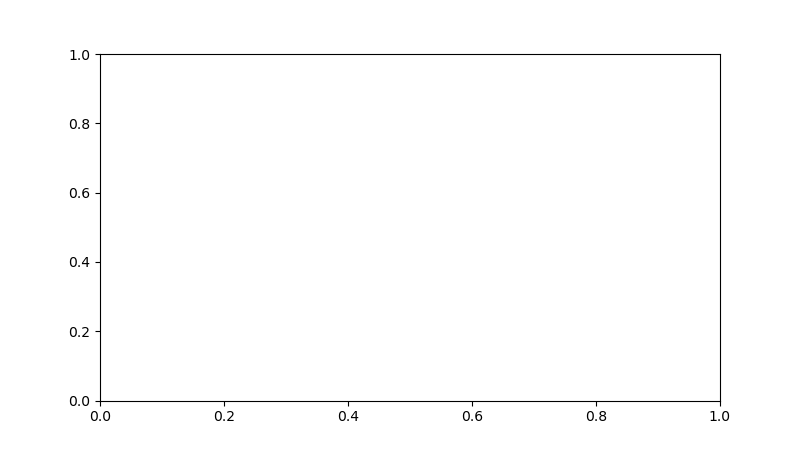

showing ...

------------------------------------------------------------------------
To scroll through the image sequence:
1) Move the slider, OR
2) Press left or right arrow key (if not responding, click the image and try again).
------------------------------------------------------------------------


In [14]:
%matplotlib notebook
mintpy.tsview.main([f'{mint_path}/timeseries_ERA5_demErr.h5', f'-d={mint_path}/inputs/geometryGeo.h5'])

# Reference material

- Mintpy reference: *Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: unwrapping error correction and noise reduction, preprint doi:[10.31223/osf.io/9sz6m](https://eartharxiv.org/9sz6m/).*

- University of Miami online time-series viewer: https://insarmaps.miami.edu/

- Mintpy Github repository: https://github.com/insarlab/MintPy

<font face="Calibri" size="2"> <i>MintPy_Time_Series_From_Prepared_Data_Stack.ipynb - Version 0.1 - September 2021
<br>
</i>
</font>

In [ ]:
dirs = ['*20150410*20160428*','*20150715*20160709*','*20160311*20160404*','*20160311*20160428*','*20160311*20170324*','*20160404*20160428*','*20160428*20160615*','*20160428*20170417*','*20160615*20160709*','*20160615*20160802*','*20160709*20160802*','*20160709*20160826*','*20160802*20160826*','*20160802*20160919*','*20160826*20160919*','*20160919*20161019*']

In [ ]:
for i in range(len(dirs)):
    dir2remove = dirs[i]
    runcommand = f"rm -rf /home/jovyan/notebooks/avo_insar/processings/ukinrek102/{dir2remove}"
    !{runcommand}

In [ ]:
runcommand = f"rm -rf /home/jovyan/notebooks/avo_insar/processings/ukinrek102/MintPy"
!{runcommand}

In [22]:
!plot_network.py /home/jovyan/notebooks/avo_insar/processings/yunaska66/MintPy/inputs/ifgramStack.h5 -t /home/jovyan/notebooks/avo_insar/processings/yunaska66/MintPy/smallbaselineApp.cfg -d coherence -v 0.2 1.0

read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: /home/jovyan/notebooks/avo_insar/processings/yunaska66/MintPy/inputs/ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['/home/jovyan/notebooks/avo_insar/processings/yunaska66/MintPy/inputs/ifgramStack.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 75
number of interferograms: 211
shift all perp baseline by 93.26280212402344 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 211
number of acquisitions marked as drop: 0
max perpendicular baseline: 207.98 m
max temporal      baseline: 708.0 days
showing coherence
data range: [0.2948, 0.5679]
display range: [0.2, 1.0]
showing ...
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


run view.py in MintPy version v1.3.2, date 2021-11-21
input file is ifgramStack file: /home/jovyan/notebooks/avo_insar/processings/yunaska66/MintPy/inputs/ifgramStack.h5 in float32 format
file size in y/x: (162, 299)
input dataset: "['coherence']"
num of datasets in file ifgramStack.h5: 422
num of datasets to exclude: 0
num of datasets to display: 211
data   coverage in y/x: (0, 0, 299, 162)
subset coverage in y/x: (0, 0, 299, 162)
data   coverage in lat/lon: (-170.8500949048849, 52.70562954703164, -170.55039731323046, 52.543251587673716)
subset coverage in lat/lon: (-170.8500949048849, 52.70562954703164, -170.55039731323046, 52.543251587673716)
------------------------------------------------------------------------
colormap: gray
figure title: coherence
figure size : [15.00, 15.00]
dataset number: 211
row     number: 14
column  number: 8
figure  number: 2
consider reference pixel in y/x: [112, 104]
----------------------------------------
Figure 1 - coherence_1.png
reading data as a 

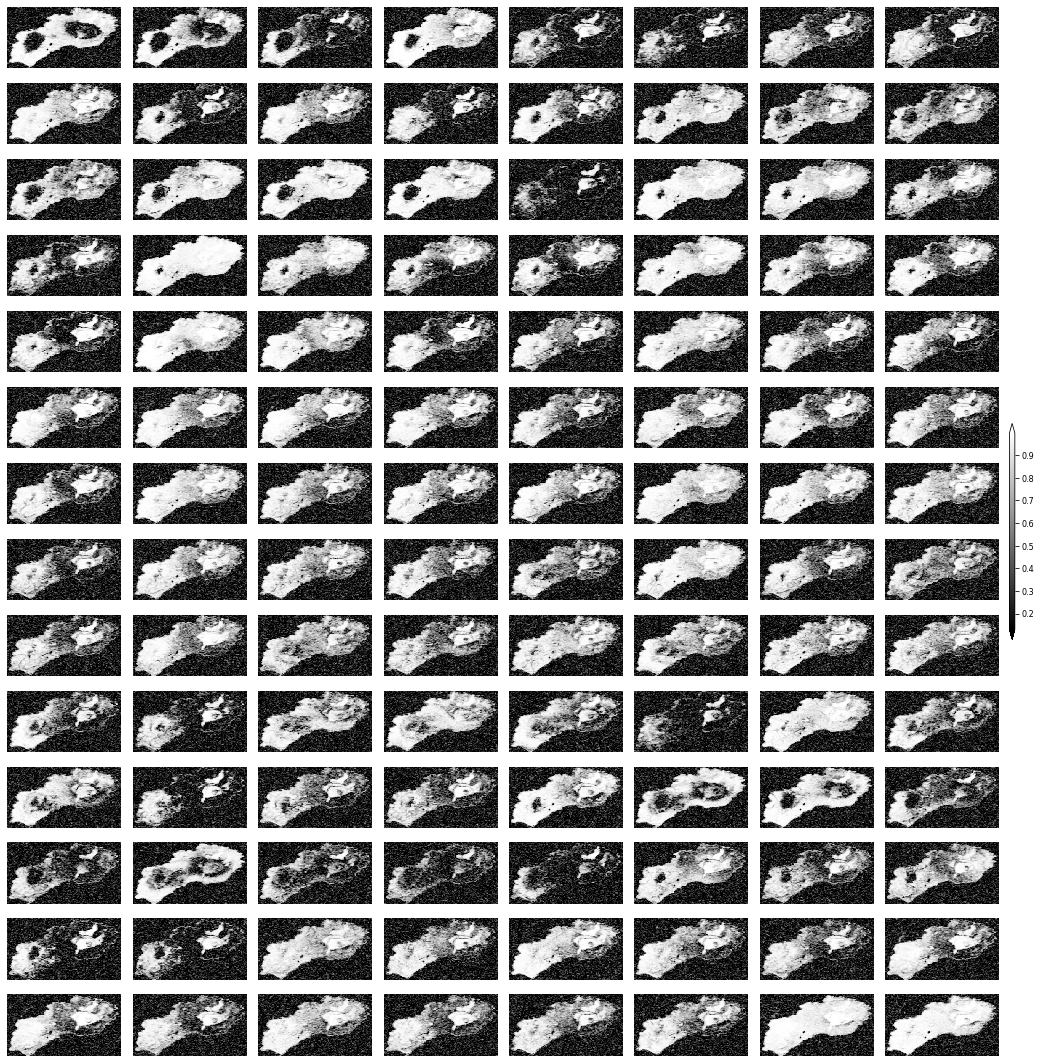

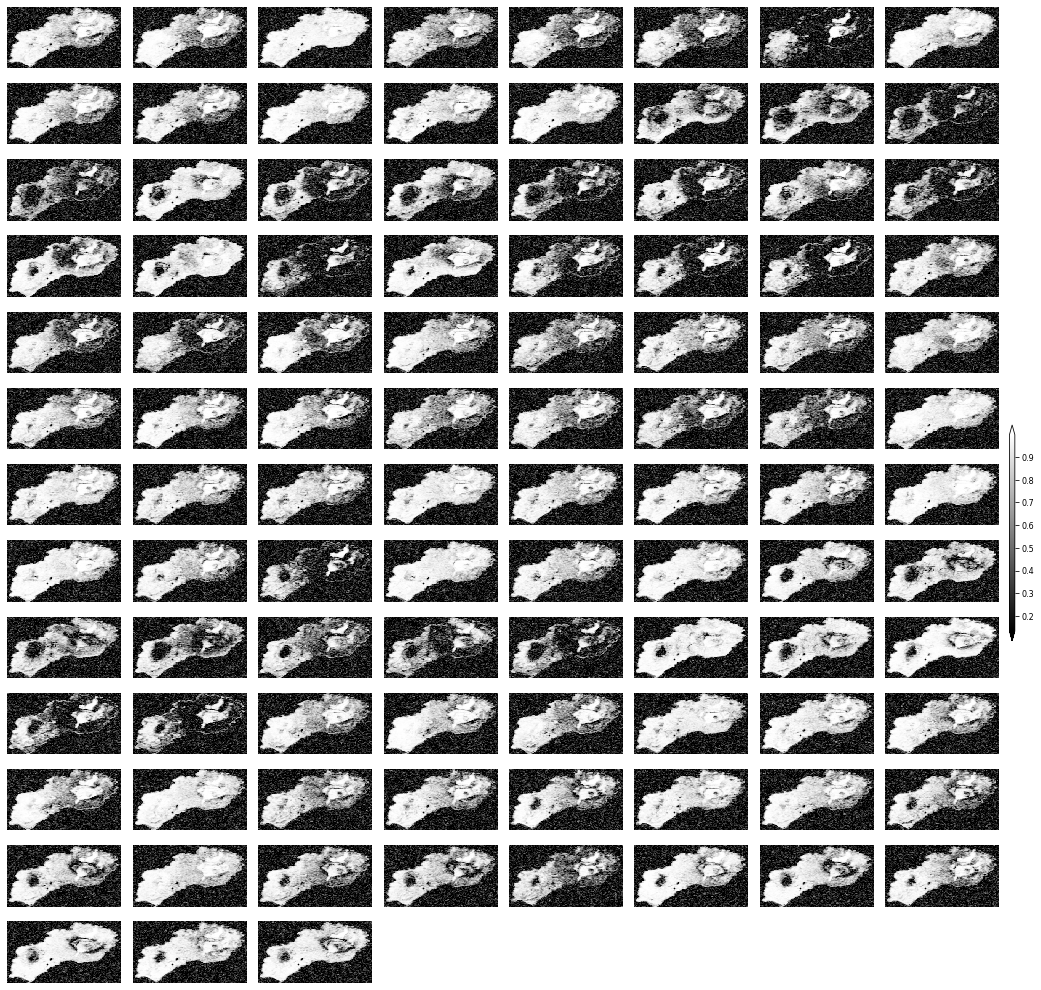

In [25]:
scp_args = f'{mint_path}/inputs/ifgramStack.h5 coherence --notitle --notick --noaxis --dpi 600 --figsize 15 15'
mintpy.view.main(scp_args.split())